In [1]:
import astropy

In [2]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [3]:
#starship specs
isp = 380
dry_mass = 150
prop_mass = 1600 #tons
lmo_fuel = 250


landing_reserve = 0

starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
# boiloff = 0#0 
print(starship_dv)

# #for a skimpy 100t starship, only need 20 tons of landing fuel
# print(isp*9.81*math.log((120)/(100)))



9158.219613923256


In [4]:

#launch from body_1 to body_2
body_1 = Earth
body_2 = Jupiter
# print(body_1.escape_velocity())

#solve for a minimum ejection DV given a time period
transitTime = 700*u.day
resolution = 1*u.day
start_date = time.Time("2035-03-20 00:01", scale="utc").tdb
end_date = time.Time("2035-10-09 00:01", scale="utc").tdb
print(type(time_range(start_date, end=end_date+transitTime)))

<class 'astropy.time.core.Time'>


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



In [5]:
# print(end_date - start_date)

In [6]:


ephem_1 = Ephem.from_body(body_1, time_range(start_date, end=end_date+transitTime))
ephem_2 = Ephem.from_body(body_2, time_range(start_date, end=end_date+transitTime))


delta_time = end_date-start_date
lowest_dv = 100000
lowest_date = 0
lowest_orb = 0
for i in range(int(delta_time/resolution)):
    date_launch = start_date+i*resolution
    date_arrival = start_date+transitTime+i*resolution
    # Solve for departure and target orbits
    ss_planet_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)
    ss_planet_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)

    # Solve for the transfer maneuver
    man_lambert = Maneuver.lambert(ss_planet_1, ss_planet_2,M=0)
    ejection = man_lambert[0]
    dv = np.linalg.norm(ejection[1].value)
    if(dv<lowest_dv):
        lowest_dv=dv
        lowest_date = date_launch
        lowest_orb,final = ss_planet_1.apply_maneuver(man_lambert, intermediate=True)


reserve_dv = starship_dv-int(lowest_dv)-landing_reserve
#print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection is with {int((1)*lowest_dv)}m/s of DV (in sun reference frame, so actual number is different)")
#print(f"Reserve DV (not accounting for boiloff) is {reserve_dv}m/s")
print(f"departure from {body_1} on {lowest_date}")
print(f"arrival at {body_2} on {lowest_date+transitTime}")
      
dM = 0*u.day

# fig, ax = plt.subplots()

# ax.grid(True)
#ax.set_title("2033 90 day trajectory")



Ejection is with 9132m/s of DV (in sun reference frame, so actual number is different)
departure from Earth (♁) on 2035-07-18 00:02:09.186
arrival at Jupiter (♃) on 2037-06-17 00:02:09.186


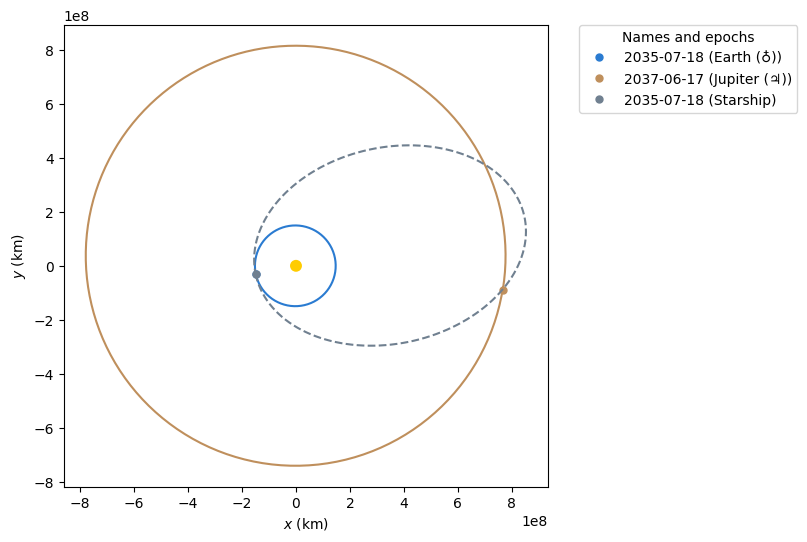

In [7]:
# We can check new bodies positions
plotter = StaticOrbitPlotter()
ss_leave_1 = Orbit.from_ephem(Sun, ephem_1, lowest_date)
ss_arrival_2 = Orbit.from_ephem(Sun, ephem_2, lowest_date+transitTime)

plotter.plot_body_orbit(body_1,  lowest_date+dM, label=body_1)

plotter.plot_body_orbit(body_2,  lowest_date+dM+transitTime, label=body_2)
label_str = lowest_date.datetime.strftime("%Y-%m-%d")


#plotter.plot(ss_leave_1, label=label_str)

plotter.plot(lowest_orb, color="slategrey", label="Starship")

In [8]:
#Find SOI change on departure
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_1.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_1.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference>0):
        print(f"Departure at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Departed SOI on {soi_change_point}")



70300 steps
Departure at step8
Departed SOI on 2035-07-18 01:57:21.186


Soi change at 265736.16196057346 km (potentially seems low tbf)
C3 is 83.40443012603437 km2 / s2
Ejection towards Jupiter (♃) from Earth (♁)
Starship DV is 9158.219613923256m/s
Ejection velocity is 14.336042277361567 km / s
Ejection DV is 6.522026726690331 km / s
Ejection C3 is 83.40443012603438
Starship has 2636.1928872329254 m / s of DV after the burn excluding landing reserve (0 m/s)


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



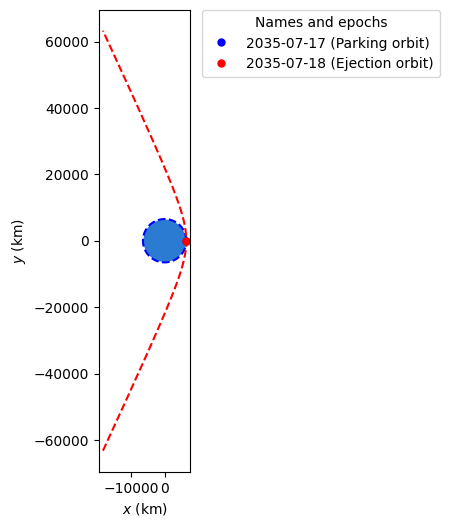

In [9]:
ss_final = lowest_orb.propagate(soi_change_point-date_launch) 


r_body_1, v_body_1 = ss_body_1.r,ss_body_1.v
r_sc_arriv = ss_final.r-r_body_1
v_sc_arriv = ss_final.v-v_body_1
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 150*u.km#parking orbit

parking_orbit = Orbit.circular(body_1,alt = r_p,epoch = date_launch-1*u.day)


a_exit = -(body_1.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_1.R) / a_exit

departure_orbit = Orbit.from_classical(
    body_1,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_launch, scale="utc"),
)
print(f"Ejection towards {body_2} from {body_1}")
print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection velocity is {np.linalg.norm(departure_orbit.v)}")
print(f"Ejection DV is {np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)}")
ejection_c3 = -(body_1.k/(departure_orbit.a.to(u.m))).value/1000000
print(f"Ejection C3 is {ejection_c3}")



ejection_dv = (np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)).value
reserve_dv = starship_dv-(ejection_dv*1000)-landing_reserve
print(f"Starship has {reserve_dv} m / s of DV after the burn excluding landing reserve ({landing_reserve} m/s)")

earth_plotter = StaticOrbitPlotter()

earth_plotter.plot(parking_orbit, label="Parking orbit", color="b")
earth_plotter.plot(departure_orbit, label="Ejection orbit", color="r")


In [10]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_2.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_2.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference<0):
        print(f"arrival at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Normal arrival would be {date_arrival}")
print(f"Actual arrival at {soi_change_point}")



70300 steps
arrival at step67096
Normal arrival would be 2037-06-17 00:02:09.186
Actual arrival at 2037-05-18 23:04:33.186


Soi change at 23387518.807792984 km (potentially seems low tbf)
C3 is 56.11220540490024 km2 / s2
Arrival speed (at periapsis) would be 53.1604388028837 km / s
Burn is 2636.1928872329254 m/s
After deacceleration burn it is 8.353232573586588 km / s
Pre Entry orbit characteristics are periapsis 19999.999999999884 km and apoapsis -4679390.425862336 km
Entry C3 is 56.112205404900514 km^2/s^2
Sus C3 is -756.0752430267212 km2 / s2
Need to lose -44.27679733624944 km / s in initial aerocapture pass assuming very low perijove
Time for light to travel from Earth (♁) to Jupiter (♃) at arrival time is 51.2 minutes


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA

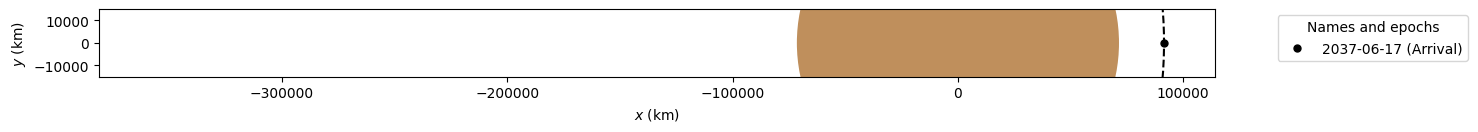

In [16]:
#ITS BROKEN AND I UNDERSTAND WHY



retro_time = 400*u.second #how long before entry interface to do the retro burn

ss_final = lowest_orb.propagate(soi_change_point-date_launch) 

b1_arrival_1 = Orbit.from_ephem(Sun, ephem_1, lowest_date+transitTime)
b1_arrival_2 = Orbit.from_ephem(Sun, ephem_2, lowest_date+transitTime)
planDist = np.linalg.norm((b1_arrival_1.r-b1_arrival_2.r).value)

r_body_2, v_body_2 = ss_body_2.r,ss_body_2.v
r_sc_arriv = ss_final.r-r_body_2
v_sc_arriv = ss_final.v-v_body_2
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 20000*u.km#arrival periapsis
a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit

arrival_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_arrival, scale="utc"),
)


pre_burn_orbit = arrival_orbit.propagate(-retro_time)
#perform the retro burn
prograde_vector = (pre_burn_orbit.v/(np.linalg.norm(pre_burn_orbit.v))).value
#offset by a little as we dont want periapsis going into the atmosphere
rad_vector = (pre_burn_orbit.r/(np.linalg.norm(pre_burn_orbit.r))).value
rad_offset_weight = 0.1
retro_vector = -(prograde_vector-rad_offset_weight*rad_vector)
retro_vector = retro_vector/np.linalg.norm(retro_vector)

# print(prograde_vector)


##no deaccleration burn for arriving at Earth for now


burn_dv = 0*0.001*reserve_dv*(retro_vector)
#print(burn_dv)
# else:
#     burn_dv = 0*prograde_vector

retro_burn = Maneuver((0*u.s,burn_dv*u.km/u.s))
#retro_burn = Maneuver((0*u.s,[0,1,0]*u.km/u.s))
post_burn_orbit = pre_burn_orbit.apply_maneuver(retro_burn)

#print(f"New periapsis is {post_burn_orbit.r_p-body_2.R}km")

ax = plt.gca()       # or plotter.ax if you stored it directly
ax.set_ylim([-1.5e4, 1.5e4]) 

earth_plotter = StaticOrbitPlotter(ax)

#print(f"State vectors post burn are {post_burn_orbit.r} and {post_burn_orbit.v}.")



earth_plotter.plot(arrival_orbit, label="Arrival", color="k")
#earth_plotter.

# print(post_burn_orbit.v)
# print(post_burn_orbit.r)

post_burn_orbit_periapsis = post_burn_orbit.propagate(-post_burn_orbit.t_p)
# earth_plotter.plot(post_burn_orbit, label="Arrival", color="b")

arrival_circular_orbit = Orbit.circular(body_2,alt = 200*u.km)


print(f"Arrival speed (at periapsis) would be {np.linalg.norm(arrival_orbit.v)}")
print(f"Burn is {reserve_dv} m/s")
print(f"After deacceleration burn it is {np.linalg.norm(post_burn_orbit_periapsis.v)}")
print(f"Pre Entry orbit characteristics are periapsis {post_burn_orbit.r_p-body_2.R} and apoapsis {post_burn_orbit.r_a-body_2.R}")

#post_burn_c3 = ((np.linalg.norm(post_burn_orbit.v)-(body_2.escape_velocity()))**2)

post_burn_c3 = -(body_2.k/(post_burn_orbit.a.to(u.m))).value/1000000
#something unknown that is likely wrong
sus_c3 = (np.linalg.norm(post_burn_orbit.v)**2-body_2.escape_velocity()**2)



print(f"Entry C3 is {post_burn_c3} km^2/s^2")
print(f"Sus C3 is {sus_c3}")


# print(f"Need to lose {np.linalg.norm(post_burn_orbit_periapsis.v)-body_2.escape_velocity()} in initial aerocapture pass")


# escape_at_alt = (2*body_2.k/(body_2.R+r_p))**0.5
# print(escape_at_alt)


print(f"Need to lose {np.linalg.norm(post_burn_orbit_periapsis.v)-body_2.escape_velocity_at_alt(r_p)} in initial aerocapture pass assuming very low perijove")



print(f"Time for light to travel from {body_1} to {body_2} at arrival time is {planDist/(3*1e5*60):.1f} minutes")


####code below tries to calculate real orbit, but patched conics problems force a c3 only calculation orbit tbf

# #grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-Earth.mass/(np.linalg.norm(r_sc_arriv)**2)
# print(grav_difference)

# arrival_orbit = Orbit.from_vectors(Earth,r_sc_arriv,v_sc_arriv,epoch=date_arrival-offset_time)
# #arrival_orbit = arrival_orbit.propagate(0.3*u.day)
# print(arrival_orbit)
# print(f"This orbit gets to within {arrival_orbit.r_p-Earth.R} of the surface of earth")
# print(f"Earth position at {lowest_date}")

# earth_plotter = StaticOrbitPlotter()

# earth_plotter.plot(arrival_orbit, label="earth Arrival", color="k")



Baseline hyperbolic approach:
  C3: 56.11220540490024 km2 / s2
  V∞ at periapsis: 53.160 km / s
  Periapsis: 91492 km

Scanning delta-v from 0 to 3.0 km / s...


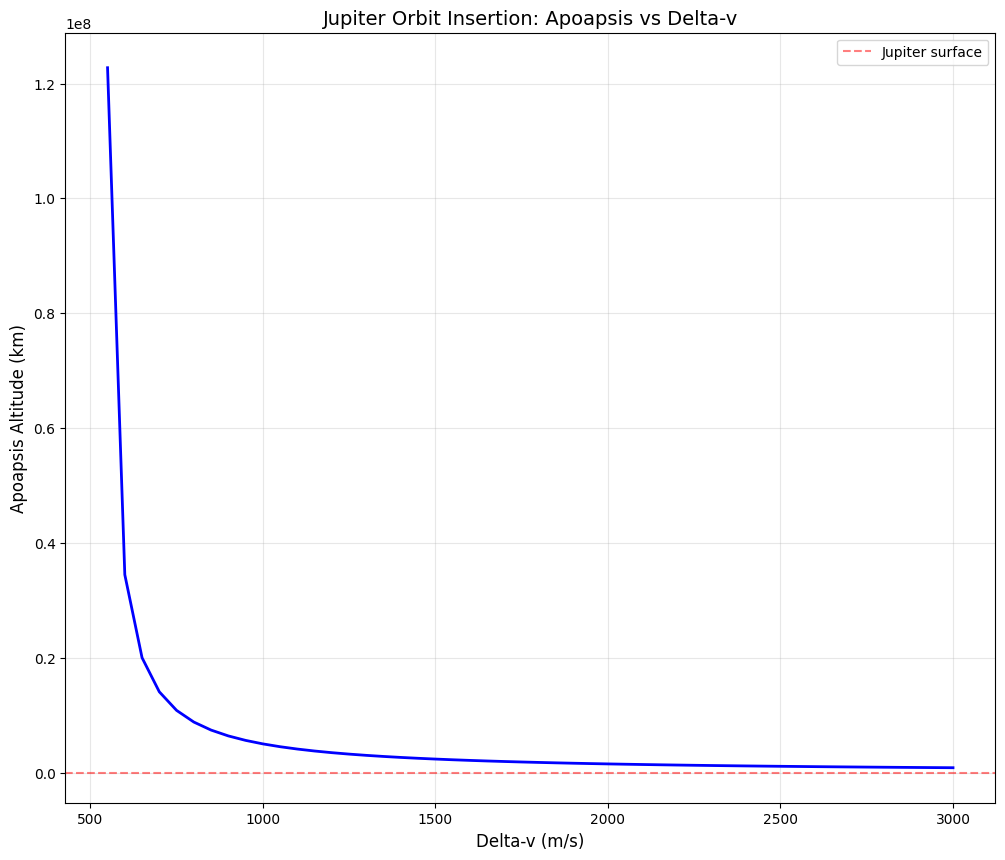

In [ ]:
## Calculate apoapsis reduction vs delta-v for Jupiter orbit insertion

# Parameters
c3_arrival = c3_a  # From previous calculation
r_perijove = r_p + body_2.R  # Periapsis distance from Jupiter center
max_dv = 3 * u.km / u.s  # Maximum delta-v to test
dv_step = 0.05 * u.km / u.s  # Delta-v step size

# Arrays to store results
dv_values = []
apoapsis_values = []
period_values = []

# Calculate baseline (no burn) apoapsis
a_hyp = -(body_2.k / c3_arrival).to(u.km)
ecc_hyp = 1 - r_perijove / a_hyp
baseline_orbit = Orbit.from_classical(
    body_2,
    a_hyp,
    ecc_hyp,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    time.Time(date_arrival, scale="utc"),
)
v_inf = np.linalg.norm(baseline_orbit.v)

print(f"Baseline hyperbolic approach:")
print(f"  C3: {c3_arrival}")
print(f"  V∞ at periapsis: {v_inf.to(u.km/u.s):.3f}")
print(f"  Periapsis: {r_perijove.to(u.km):.0f}")
print(f"\nScanning delta-v from 0 to {max_dv}...")

# Loop over delta-v values
current_dv = 0 * u.km / u.s
while current_dv <= max_dv:
    # Calculate velocity after retrograde burn
    v_after_burn = v_inf - current_dv
    
    # Calculate new orbit parameters
    # Specific energy: ε = v²/2 - μ/r
    epsilon = (v_after_burn**2 / 2) - (body_2.k / r_perijove)
    
    # Semi-major axis: a = -μ/(2ε)
    a_capture = -body_2.k / (2 * epsilon)
    
    # Eccentricity: e = 1 - r_p/a
    ecc_capture = 1 - r_perijove / a_capture
    
    # Check if orbit is elliptical (captured)
    if ecc_capture < 1.0:
        # Calculate apoapsis: r_a = a(1 + e)
        r_apoapsis = a_capture * (1 + ecc_capture)
        
        # Create the orbit to get period
        capture_orbit = Orbit.from_classical(
            body_2,
            a_capture,
            ecc_capture,
            0 * u.deg,
            0 * u.deg,
            0 * u.deg,
            0 * u.deg,
            time.Time(date_arrival, scale="utc"),
        )
        
        dv_values.append(current_dv.to(u.m/u.s).value)
        apoapsis_values.append((r_apoapsis - body_2.R).to(u.km).value)
        period_values.append(capture_orbit.period.to(u.day).value)
    else:
        # Still hyperbolic - no capture
        dv_values.append(current_dv.to(u.m/u.s).value)
        apoapsis_values.append(np.inf)
        period_values.append(np.inf)
    
    current_dv += dv_step

# Convert to arrays for plotting
dv_values = np.array(dv_values)
apoapsis_values = np.array(apoapsis_values)
period_values = np.array(period_values)

# Convert Jupiter radius to km for scaling
R_J = Jupiter.R.to(u.km).value

# Plot results
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 10))

# Plot 1: Apoapsis vs Delta-v (in R_J)
# Filter out infinite values for plotting
finite_mask = np.isfinite(apoapsis_values)
apoapsis_RJ = apoapsis_values[finite_mask] / R_J  # Convert to R_J
ax1.plot(dv_values[finite_mask], apoapsis_RJ, 'b-', linewidth=2)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Jupiter surface')
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('Delta-v (m/s)', fontsize=12)
ax1.set_ylabel('Apoapsis Altitude ($R_J$)', fontsize=12)
ax1.set_title('Jupiter Orbit Insertion: Apoapsis vs Delta-v', fontsize=14)

# Add reference lines for Galilean moons
moon_altitudes_RJ = {
    'Io': (Io.a - Jupiter.R).to(u.km).value / R_J,
    'Europa': (Europa.a - Jupiter.R).to(u.km).value / R_J,
    'Ganymede': (Ganymede.a - Jupiter.R).to(u.km).value / R_J,
    'Callisto': (Callisto.a - Jupiter.R).to(u.km).value / R_J,
}
for moon_name, altitude_RJ in moon_altitudes_RJ.items():
    ax1.axhline(y=altitude_RJ, linestyle=':', alpha=0.3, label=f'{moon_name} orbit')

ax1.legend(loc='upper right')

print(f"\nJupiter radius: {R_J:.0f} km")
print(f"\nKey results:")
if len(dv_values[finite_mask]) > 0:
    print(f"Minimum ΔV for capture: {dv_values[finite_mask][0]:.1f} m/s")
    print(f"  → Apoapsis: {apoapsis_RJ[0]:.1f} R_J ({apoapsis_values[finite_mask][0]:.0f} km)")
    print(f"  → Period: {period_values[finite_mask][0]:.1f} days")
    
    # Find ΔV needed to reach each moon's orbit
    print(f"\nΔV to reach moon orbits:")
    for moon_name, altitude_RJ in moon_altitudes_RJ.items():
        # Find closest apoapsis to moon altitude
        diff = np.abs(apoapsis_RJ - altitude_RJ)
        if len(diff) > 0:
            closest_idx = np.argmin(diff)
            required_dv = dv_values[finite_mask][closest_idx]
            actual_apo_RJ = apoapsis_RJ[closest_idx]
            print(f"  {moon_name}: {required_dv:.1f} m/s → apoapsis {actual_apo_RJ:.1f} R_J (target {altitude_RJ:.1f} R_J)")
